In [1]:
import torch
from data_loader import CustomDataLoader
from torch.utils.data import DataLoader
import ukis_metrics.seg_metrics as segm
from inference_utils import get_model, evaluate_model 

import warnings
warnings.filterwarnings('ignore')

In [2]:
model_ckpt = './networks/2024_04_16-16_37_36_encoder_efficientnet-b0_weights_imagenet_epochs_100_batchsize_16_lr_0.001/model_0.38835_val_avg.pt'
model, channels = get_model(model_ckpt)

Model parameters:
{'epochs': 100, 'batch_size': 16, 'lr': 0.001, 'encoder': 'efficientnet-b0', 'weights': 'imagenet', 'model_ckpt_path': './networks', 'data_path': '../data_prepped', 'channels': 'r.g.b'}


In [3]:
data_path = '../denmark_data'
image_path = data_path + '/{}/img/*'
mask_path = data_path + '/{}/msk/*'
 
# Use custom data loaders for Danish dataset
test_dataset = CustomDataLoader(image_path.format('test'), mask_path.format('test'), channels = channels)
test_loader = DataLoader(dataset = test_dataset, batch_size = 8, shuffle = False, num_workers = 8)

# Calculate the performance of the UNet model on the Danish dataset
images, masks, preds = evaluate_model(test_loader, model, thresholds = [0.1, 0.2, 0.4, 0.8], norm = True)

100%|███████████████████████████████████████████████████████████████████████████████| 6896/6896 [09:41<00:00, 11.87it/s]


0.1 {'iou': 0.0182, 'recall': 0.8172, 'precision': 0.0183, 'acc': 0.0332, 'F1': 0.0358, 'kappa': -0.0075}


100%|███████████████████████████████████████████████████████████████████████████████| 6896/6896 [09:36<00:00, 11.97it/s]


0.2 {'iou': 0.0176, 'recall': 0.7838, 'precision': 0.0177, 'acc': 0.0381, 'F1': 0.0346, 'kappa': -0.0088}


100%|███████████████████████████████████████████████████████████████████████████████| 6896/6896 [09:51<00:00, 11.66it/s]


0.4 {'iou': 0.0169, 'recall': 0.7392, 'precision': 0.017, 'acc': 0.053, 'F1': 0.0332, 'kappa': -0.0102}


100%|███████████████████████████████████████████████████████████████████████████████| 6896/6896 [09:13<00:00, 12.46it/s]

0.8 {'iou': 0.0171, 'recall': 0.567, 'precision': 0.0173, 'acc': 0.2841, 'F1': 0.0337, 'kappa': -0.0094}


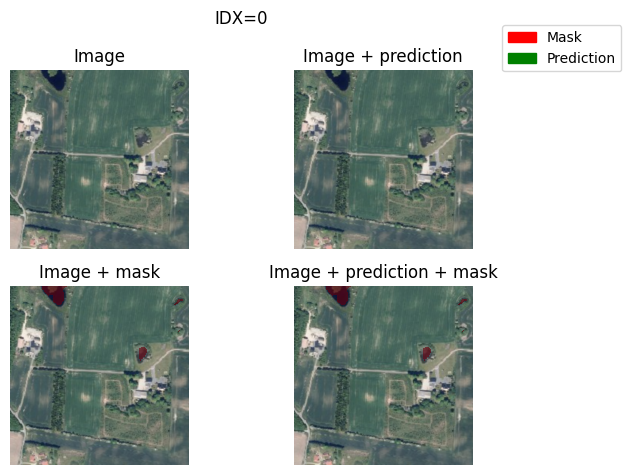

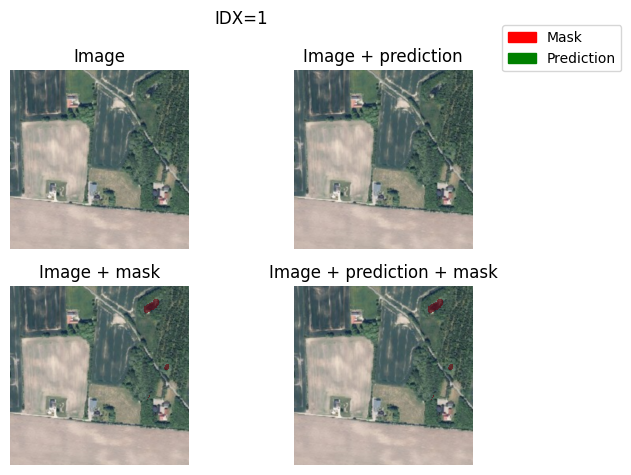

In [23]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import random
import numpy as np
import os

os.makedirs('results', exist_ok = True)
for idx in range(images.shape[0]):
    # idx = random.randint(0, images.shape[0]-1) # 5
    # print(f'idx = {idx}')
    
    # Example image: has shape (1, 3, 512, 512)
    # We squeeze the first dimension -> (3, 512, 512)
    # Then transpose so the RGB channels are last -> (512, 512, 3)
    # And make sure the colors are integers in the range 0...255
    example_image = np.squeeze(images[idx].cpu().numpy())*255
    example_image = np.round(example_image).astype(int)
    example_image = example_image.transpose(1,2,0)
    
    # Also squeeze dimensions of the predictions and mask
    # By using a masked version, we make the imshow transparent if there is no water
    example_pred = np.squeeze(preds[idx].cpu().numpy()).astype(int)
    example_pred = np.ma.masked_where(example_pred == 0, example_pred)
    
    
    example_mask = np.squeeze(masks[idx].cpu().numpy()).astype(int)
    example_mask = np.ma.masked_where(example_mask == 0, example_mask)
    
    fig, axs = plt.subplots(2, 2)
    for ax_row in axs:
        for ax in ax_row:
            ax.imshow(example_image[:, :, :3])
            ax.axis('off')
    
    axs[0, 1].imshow(example_pred, alpha = 0.6, vmin = 0, vmax = 1, cmap = 'Greens')
    axs[1, 1].imshow(example_pred, alpha = 0.6, vmin = 0, vmax = 1, cmap = 'Greens')
    
    axs[1, 0].imshow(example_mask, alpha = 0.6, vmin = 0, vmax = 1, cmap = 'Reds')
    axs[1, 1].imshow(example_mask, alpha = 0.6, vmin = 0, vmax = 1, cmap = 'Reds')
    
    
    axs[0, 0].set_title("Image")
    axs[0, 1].set_title("Image + prediction")
    axs[1, 0].set_title("Image + mask")
    axs[1, 1].set_title("Image + prediction + mask")

    fig.suptitle(f'IDX={idx}')
    
    plt.tight_layout()

    red_patch = mpatches.Patch(color='red', label='Mask')
    blue_patch = mpatches.Patch(color='green', label='Prediction')
    plt.legend(handles=[red_patch, blue_patch], loc="upper center", bbox_to_anchor=(1.5, 2.5))
    
    plt.savefig(f'./results/{idx}.png', bbox_inches='tight', transparent = True)
    plt.show()